In [1]:
import torch, noise_model
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random, copy, numpy as np
import matplotlib.pyplot as plt
import train_fp

In [2]:
train_loader, test_loader = train_fp.load_data()
criterion = nn.CrossEntropyLoss()
num_epochs = 200
nm = noise_model.RRAMNonidealities()

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [3]:
mode_relu = train_fp.Model(train_loader, test_loader, criterion, optim.AdamW, num_epochs=num_epochs, activation_type='relu')
model_grrelu = train_fp.Model(train_loader, test_loader, criterion, optim.AdamW, num_epochs=num_epochs, activation_type='grrelu')

In [4]:
# Load models
mode_relu.net.load_state_dict(torch.load(f'./best_model_relu.pth', weights_only=False))
# model_grrelu.net.load_state_dict(torch.load(f'./best_model_grrelu_slope_0.1x_addmul_noise_learable.pth', weights_only=False))
model_grrelu.net.load_state_dict(torch.load(f'./best_model_grrelu.pth', weights_only=False))
mode_relu.eval(test_loader), model_grrelu.eval(test_loader)

(94.06, 91.3)

In [5]:
nm = noise_model.RRAMNonidealities(
    d2d_std=0.3,
)

In [6]:
noisy_mode_relu = nm.apply_device_to_device_variation(mode_relu.net)
mode_relu.net = noisy_mode_relu
mode_relu.eval(test_loader)

71.35

In [7]:
noisy_mode_relu = nm.apply_device_to_device_variation(model_grrelu.net)
model_grrelu.net = noisy_mode_relu
model_grrelu.eval(test_loader)

87.14

In [20]:
model_grrelu.net.activation.raw_std_scale.exp(), model_grrelu.net.activation.raw_std_shift.exp()

(tensor(0.0473, device='cuda:0', grad_fn=<ExpBackward0>),
 tensor(0.0537, device='cuda:0', grad_fn=<ExpBackward0>))

In [24]:
a = (torch.randn(1000)*0.3) + 0.1
a.mean(), a.std()

(tensor(0.0986), tensor(0.2930))


Evaluating models with different noise levels:
Alpha=0.0:
  Completed 10/100 evaluations of alpha=0.0
  Completed 20/100 evaluations of alpha=0.0
  Completed 30/100 evaluations of alpha=0.0
  Completed 40/100 evaluations of alpha=0.0
  Completed 50/100 evaluations of alpha=0.0
  Completed 60/100 evaluations of alpha=0.0
  Completed 70/100 evaluations of alpha=0.0
  Completed 80/100 evaluations of alpha=0.0
  Completed 90/100 evaluations of alpha=0.0
  Completed 100/100 evaluations of alpha=0.0
  ReLU Mean Accuracy: 94.06% ± 0.00%
  gRReLU Mean Accuracy: 93.85% ± 0.00%
Alpha=0.1:
  Completed 10/100 evaluations of alpha=0.1
  Completed 20/100 evaluations of alpha=0.1
  Completed 30/100 evaluations of alpha=0.1
  Completed 40/100 evaluations of alpha=0.1
  Completed 50/100 evaluations of alpha=0.1
  Completed 60/100 evaluations of alpha=0.1
  Completed 70/100 evaluations of alpha=0.1
  Completed 80/100 evaluations of alpha=0.1
  Completed 90/100 evaluations of alpha=0.1
  Completed 100/1

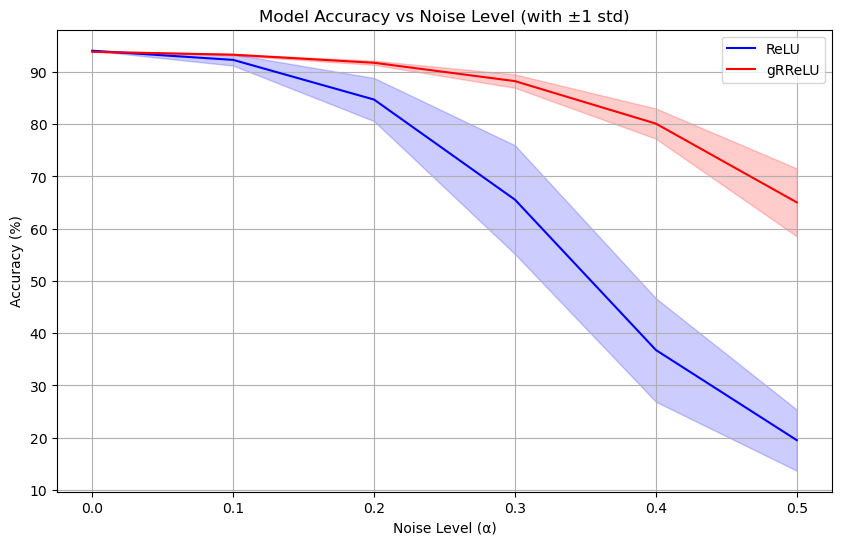

In [11]:
seed = 2024
train_fp.set_seed(seed)

# Lists to store results
alphas = np.arange(0, .6, 0.1)
K = 100  # Number of evaluations per alpha
relu_accuracies_all = []
grrelu_accuracies_all = []

print("\nEvaluating models with different noise levels:")
for alpha in alphas:
    nm.d2d_std = alpha
    relu_accuracies_alpha = []
    grrelu_accuracies_alpha = []
    
    print(f"Alpha={alpha:.1f}:")
    for k in range(K):
        # Evaluate ReLU model
        mode_relu = train_fp.Model(train_loader, test_loader, criterion, optim.AdamW, num_epochs=num_epochs, activation_type='relu')
        model_grrelu = train_fp.Model(train_loader, test_loader, criterion, optim.AdamW, num_epochs=num_epochs, activation_type='grrelu')
        # Load models
        # model_grrelu.net.load_state_dict(torch.load(f'./best_model_grrelu_slope_0.1x_addmul_noise_learable.pth', weights_only=False))
        model_grrelu.net.load_state_dict(torch.load(f'./best_model_grrelu.pth', weights_only=False))

        mode_relu.net.load_state_dict(torch.load(f'./best_model_relu.pth', weights_only=False))
        # model_grrelu.net.load_state_dict(torch.load(f'./best_model_grrelu_pos.pth', weights_only=True))

        # mode_relu_copy = copy.deepcopy(mode_relu.net)
        # inject_noise(mode_relu_copy, alpha=alpha)
        noisy_mode_relu = nm.apply_device_to_device_variation(mode_relu.net)
        mode_relu.net = noisy_mode_relu
        relu_acc = mode_relu.eval(test_loader)
        relu_accuracies_alpha.append(relu_acc)
        
        # Evaluate gRReLU model
        # model_grrelu_copy = copy.deepcopy(model_grrelu.net)
        # inject_noise(model_grrelu_copy, alpha=alpha)
        noisy_mode_relu = nm.apply_device_to_device_variation(model_grrelu.net)
        model_grrelu.net = noisy_mode_relu
        grrelu_acc = model_grrelu.eval(test_loader)
        grrelu_accuracies_alpha.append(grrelu_acc)
        
        if (k + 1) % 10 == 0:
            print(f"  Completed {k + 1}/{K} evaluations of alpha={alpha:.1f}")
    
    relu_accuracies_all.append(relu_accuracies_alpha)
    grrelu_accuracies_all.append(grrelu_accuracies_alpha)
    
    print(f"  ReLU Mean Accuracy: {np.mean(relu_accuracies_alpha):.2f}% ± {np.std(relu_accuracies_alpha):.2f}%")
    print(f"  gRReLU Mean Accuracy: {np.mean(grrelu_accuracies_alpha):.2f}% ± {np.std(grrelu_accuracies_alpha):.2f}%")

# Calculate means and standard deviations
relu_means = np.array([np.mean(accs) for accs in relu_accuracies_all])
relu_stds = np.array([np.std(accs) for accs in relu_accuracies_all])
grrelu_means = np.array([np.mean(accs) for accs in grrelu_accuracies_all])
grrelu_stds = np.array([np.std(accs) for accs in grrelu_accuracies_all])

torch.save(relu_accuracies_all, './relu_accuracies_all.pth')
torch.save(grrelu_accuracies_all, './grrelu_accuracies_all.pth')

plt.figure(figsize=(10, 6))
# Plot ReLU with error band
plt.plot(alphas, relu_means, 'b-', label='ReLU')
plt.fill_between(alphas, relu_means - relu_stds, relu_means + relu_stds, color='b', alpha=0.2)
# Plot gRReLU with error band
plt.plot(alphas, grrelu_means, 'r-', label='gRReLU')
plt.fill_between(alphas, grrelu_means - grrelu_stds, grrelu_means + grrelu_stds, color='r', alpha=0.2)

plt.xlabel('Noise Level (α)')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy vs Noise Level (with ±1 std)')
plt.legend()
plt.grid(True)
# plt.savefig('noise_robustness_seed_'+str(seed)+'_slope_std0_addmul_noise_learable_k_'+str(k)+'_logstd.png')
# plt.close()
plt.show()

In [4]:
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

testset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
test_loader_eval = torch.utils.data.DataLoader(
    testset, batch_size=100000, shuffle=False, num_workers=2)
for x, y in test_loader_eval:
    break

Files already downloaded and verified


In [25]:
with torch.no_grad():
    model_grrelu = train_fp.Model(train_loader, test_loader, criterion, optim.AdamW, num_epochs=num_epochs, activation_type='grrelu')
    model_grrelu.net.load_state_dict(torch.load(f'./best_model_grrelu.pth', weights_only=False))
    model_grrelu.net.to('cuda:1')
    model_grrelu.net.eval()
    inter_out = model_grrelu.net.bn1(model_grrelu.net.activation(model_grrelu.net.conv1(x.to('cuda:1')))).cpu()
    print(model_grrelu.eval(test_loader, device='cuda:1'))
    
    nm = noise_model.RRAMNonidealities(d2d_std=0.3,)
    noisy_mode_relu = nm.apply_device_to_device_variation(model_grrelu.net)
    model_grrelu.net = noisy_mode_relu
    model_grrelu.net.eval()
    inter_noisy_out = model_grrelu.net.bn1(model_grrelu.net.activation(model_grrelu.net.conv1(x.to('cuda:1')))).cpu()
    print(model_grrelu.eval(test_loader, device='cuda:1'))

41.01
31.79


In [5]:
with torch.no_grad():
    model_grrelu = train_fp.Model(train_loader, test_loader, criterion, optim.AdamW, num_epochs=num_epochs, activation_type='relu')
    model_grrelu.net.load_state_dict(torch.load(f'./best_model_relu.pth', weights_only=False))
    model_grrelu.net.to('cuda:1')
    model_grrelu.net.eval()
    inter_out = model_grrelu.net.conv1(x.to('cuda:1')).cpu()
    print(model_grrelu.eval(test_loader, device='cuda:1'))
    
    nm = noise_model.RRAMNonidealities(d2d_std=0.3,)
    noisy_mode_relu = nm.apply_device_to_device_variation(model_grrelu.net)
    model_grrelu.net = noisy_mode_relu
    model_grrelu.net.eval()
    inter_noisy_out = model_grrelu.net.conv1(x.to('cuda:1')).cpu()
    print(model_grrelu.eval(test_loader, device='cuda:1'))

94.06
71.35


In [6]:
inter_out.mean(), inter_noisy_out.mean(), inter_out.std(), inter_noisy_out.std()

(tensor(-0.0004), tensor(-0.0003), tensor(0.3576), tensor(0.3736))

In [9]:
with torch.no_grad():
    model_grrelu = train_fp.Model(train_loader, test_loader, criterion, optim.AdamW, num_epochs=num_epochs, activation_type='relu')
    model_grrelu.net.load_state_dict(torch.load(f'./best_model_relu.pth', weights_only=False))
    model_grrelu.net.to('cuda:1')
    model_grrelu.net.eval()
    inter_out = model_grrelu.net.bn1(model_grrelu.net.conv1(x.to('cuda:1'))).cpu().relu()
    print(model_grrelu.eval(test_loader, device='cuda:1'))
    
    nm = noise_model.RRAMNonidealities(d2d_std=0.3,)
    noisy_mode_relu = nm.apply_device_to_device_variation(model_grrelu.net)
    model_grrelu.net = noisy_mode_relu
    model_grrelu.net.eval()
    inter_noisy_out = model_grrelu.net.bn1(model_grrelu.net.conv1(x.to('cuda:1'))).cpu().relu()
    print(model_grrelu.eval(test_loader, device='cuda:1'))

94.06
64.61


In [10]:
inter_out.mean(), inter_noisy_out.mean(), inter_out.std(), inter_noisy_out.std()

(tensor(0.0502), tensor(0.0588), tensor(0.1175), tensor(0.1662))

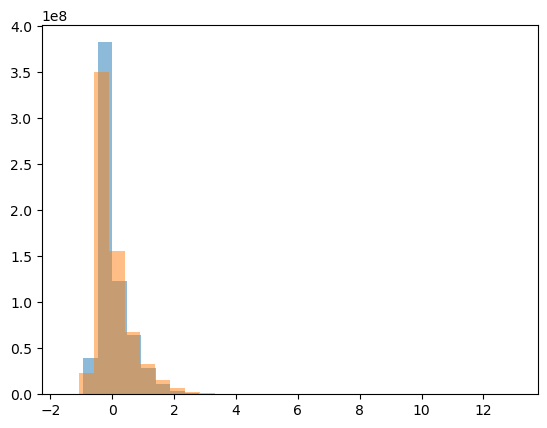

In [21]:
_ = plt.hist(inter_out.numpy().flatten(), bins=30, alpha=0.5, label='Original')
_ = plt.hist(inter_noisy_out.numpy().flatten(), bins=30, alpha=0.5, label='Noisy')